In [1]:
## In this notebook, we will use a Population Project Matrix (PPM)
# to classification model into life stages in the coming year
# using this years' size data

In [2]:
# Begin by importing libraries and data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv('Train.csv')
val = pd.read_csv('Validation.csv')

In [3]:
# Let's begin by initializing the matrix A to be used in the PPM
# It will be a 5 x 5 matrix, and the default entry will be zero
# We will initialize it as a 5 x 5 matrix of zeros, and overwrite the necessary
# entries
A = np.zeros((5,5))

In [4]:
# To begin, approximate the fecunity parameter
# This parameter will be the number of seedlings in 2004 over the number of
# flowering individuals in 2004
flowering03 = train.Stage03.value_counts()['flowering']
seedling04 = train.Stage04.value_counts()['seedling']
A[0,4] = seedling04/flowering03

In [5]:
notEmerged = val[val.Stage04 == 'not emerged']
notEmerged.groupby("Stage05").apply(len)


Stage05
flowering        1
nonflowering    10
not emerged     35
oneleaf          4
seedling        29
dtype: int64

In [6]:
# Next, begin accounting for transition probabilities

# first, we compute the probabilities of transition for seedlings
seedling = train[train.Stage03 == 'seedling']

p_sj = seedling.Trans0304.value_counts()['progression']/len(seedling)
p_sb = (seedling.Trans0304.value_counts()['dead'] + \
        seedling.Trans0304.value_counts()['enter dormancy'])/len(seedling)
A[1,0] = p_sj
A[2,0] = p_sb

del seedling

# transition probabilities for juveniles
oneleaf = train[train.Stage03 == 'oneleaf']

p_jj = oneleaf.Trans0304.value_counts()['stasis']/len(oneleaf)
p_jn = oneleaf.Trans0304.value_counts()['progression']/len(oneleaf)
p_jb = 1 - p_jj - p_jn

A[1,1] = p_jj
A[2,1] = p_jb
A[3,1] = p_jn

del oneleaf

# We do not have good data regarding transitions for not emerged plants in 2003
# Assume equal probability of transition into each stage
A[0:5,2] = 0.2
# or use A[1:4,2] = 0.0 and A[0,2] = 1.0 -> assume all non emerged plants will be
# seedlings in the future

# probabilities for nonflowering individuals
nonflowering = train[train.Stage03 == 'nonflowering']

p_nj = nonflowering.Trans0304.value_counts()['retrogression']/len(nonflowering)
p_nn = nonflowering.Trans0304.value_counts()['stasis']/len(nonflowering)
p_nr = nonflowering.Trans0304.value_counts()['progression']/len(nonflowering)
p_nb = 1.0 - p_nj - p_nn - p_nr

A[1,3] = p_nj
A[2,3] = p_nb
A[3,3] = p_nn
A[4,3] = p_nr

del nonflowering

# finally, compute probabilities for flowering individuals
flowering = train[train.Stage03 == 'flowering']

p_rn = flowering.Trans0304.value_counts()['retrogression']/len(flowering)
p_rr = flowering.Trans0304.value_counts()['statis']/len(flowering)
p_rb = 1.0 - p_rn - p_rr

A[2,4] = p_rb
A[3,4] = p_rn
A[4,4] = p_rr

del flowering

print(A)

[[0.         0.         0.2        0.         0.86666667]
 [0.63716814 0.41666667 0.2        0.04221252 0.        ]
 [0.36283186 0.1025641  0.2        0.11644833 0.13333333]
 [0.         0.48076923 0.2        0.73944687 0.23809524]
 [0.         0.         0.2        0.10189229 0.62857143]]


In [7]:
# Now, let's see how the matrix predicts the population stage in 2004. This is the
# training error

# first, we obtain stage counts
stageList = ['seedling','oneleaf','not emerged',
             'nonflowering','flowering']
N03 = np.zeros(5)
N04 = np.zeros(5)
for i in range(0,5):
    stage = stageList[i]
    N03[i] = train.Stage03.value_counts()[stage]
    N04[i] = train.Stage04.value_counts()[stage]

# use PPM to predict 2004 stage
N04_pred = A.dot(N03)

# round prediction to integer values
N04_pred = N04_pred.round(decimals = 0)

error = np.absolute(N04 - N04_pred)

# measure percentage of predicted population that is incorrect
error_rate = sum(error)/sum(N04_pred)
print('Training error rate: ',error_rate)

Training error rate:  0.07246376811594203


In [8]:
# This is a good training error rate. Let's see how it performs
# on the validation set
stageList = ['seedling','oneleaf','not emerged',
             'nonflowering','flowering']
N04 = np.zeros(5)
N05 = np.zeros(5)
for i in range(0,5):
    stage = stageList[i]
    N04[i] = val.Stage04.value_counts()[stage]
    N05[i] = val.Stage05.value_counts()[stage]

# use PPM to predict 2005 stage
N05_pred = A.dot(N04)

# round prediction to integer values
N05_pred = N05_pred.round(decimals = 0)

error = np.absolute(N05 - N05_pred)

# measure percentage of predicted population that is incorrect
error_rate = sum(error)/sum(N05_pred)
print('Validation error rate: ',error_rate)

Validation error rate:  0.2431818181818182


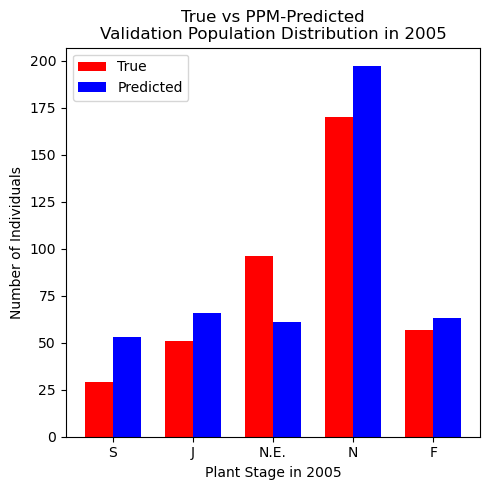

In [10]:
# Let's visualize what the predicted population looks like compared
# to the actual population

# create plot
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = 0.35
X = np.arange(5)

p1 = plt.bar(X, N05, bar_width, color='r',
    label='True')

# The bar of second plot starts where the first bar ends
p2 = plt.bar(X + bar_width, N05_pred, bar_width,
    color='b', label='Predicted')

plt.xlabel('Plant Stage in 2005')
plt.ylabel('Number of Individuals')
plt.title('True vs PPM-Predicted\nValidation Population Distribution in 2005')
plt.xticks(X + (bar_width/2) , ("S", "J","N.E.", "N", "F"))
plt.legend()

plt.tight_layout()
plt.savefig('ppmValidationPerformance.png', bbox_inches='tight')
plt.show()